# Instruction to lab work # 5: "Ultra wide Vs Deep ANN architecture"

> Student name    - Volodymyr

> Student surname - Donets

> Group           - KU-31


# Theory

Details on `universal approximation theorem` you can find in:
* [Wiki](https://en.wikipedia.org/wiki/Universal_approximation_theorem) -- here is a lot of math.
* [Reddit](https://www.reddit.com/r/MachineLearning/comments/notwbx/d_deep_learning_vs_wide_learning/) -- naive explanation.
* [Geeks4Geeks](https://www.geeksforgeeks.org/deep-learning/universal-approximation-theorem-for-neural-networks/) -- bit more detailed naive explanation.
* [YouTube](https://www.youtube.com/watch?v=wen3221_3gU) -- explanation with visualization principle of work.

# Lab environment description

1. Here you have an example of training & testing. (Here is no need for train/val/test split, you only observe performance of various configurations of ANN models wide & deep architectures).
2. Here you load maps of some places in Ukraine (with water & soil).
3. The images loaded as list of coordinates corresponding pixel class (water or soil).
4. Then trained by one example wide & deep ANN models. And observed performance on those models.

# Tasks of the lab work:

1. Set your `STUDENT_ID`.
2. Then carefully examine presented examples. 
3. Based on examples conduct your own experiments with `wide` ANN model (change number of neurons in the layer and type of the activation function on that layer). Conduct a few experiments (you can use up to 1_000_000 neurons in case of wide model). Your main goal is to learn the map using as small (in number of weights) and as accurately as possible.
4. Conduct experiments with `deep` ANN model similar to previous one, but try more inner layers (like 2, 3, ... 10, 20?) and not so much neurons at each layers (maximum 100 per layer).
5. Based on your observations do conclusions on:
   * How number of layers influence the overall ANN model performance?
   * Which model is faster learn using the same optimizer and learning configurations?
6. P.s. You, probably, need to rescale the images of maps it provides too many dots (so training might take a lot of time).
7. P.s. 2: Visually your task is to minimize amount of red zones in the classification error image.


In [ ]:
STUDENT_ID = 23

path_to_img = f"maps/map_{STUDENT_ID % 11 + 1}.jpg"
print(f"Your map image is '{path_to_img}'")

# Code part
## Import dependencies

In [ ]:
# !pip install seaborn

!pip uninstall tensorflow -y
!pip uninstall tensorflow-addons

!pip install tensorflow
!pip install tensorflow-addons

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from PIL import Image

from typing import Tuple

## Tool Functions

In [2]:
def image_to_coordinate_dataframe(
    image_path: str, 
    target_color: Tuple[int, int, int] = (144, 218, 238)
) -> pd.DataFrame:
    """
    Converts an image file into a DataFrame of coordinates (x0, x1)
    and binary labels (y).

    The label 'y' is 0 if the pixel color matches target_color, and 1 otherwise.

    Args:
        image_path (str): The file path to the image.
        target_color (Tuple[int, int, int]): An (R, G, B) tuple representing the 
                                             target color. Defaults to (144, 218, 238) - blue colour of the water.

    Returns:
        pd.DataFrame: A DataFrame with columns ['x0', 'x1', 'y'].
        
    Raises:
        FileNotFoundError: If the image_path is invalid.
        Exception: For other PIL/NumPy processing errors.
    """
    try:
        # 1. Load and process the image
        with Image.open(image_path) as img:
            
            # Convert to 'RGB' to handle potential transparency (RGBA)
            # or palettes (P) in PNGs or GIFs.
            img_rgb = img.convert('RGB')
            
            # Get image dimensions
            width, height = img_rgb.size

            # Convert the PIL Image to a NumPy array (shape: height, width, 3)
            np_img = np.array(img_rgb)

        # 2. Create coordinate and label arrays

        # A. Create the 'y' labels
        # Create a boolean mask where all 3 channels (R,G,B) match the target
        matches = np.all(np_img == target_color, axis=2)
        
        # Use np.where: 0 if True (a match), 1 if False (not a match)
        # .ravel() flattens the 2D (height, width) array into a 1D array
        y_labels = np.where(matches, 0, 1).ravel()

        # B. Create the 'x0' (horizontal) and 'x1' (vertical) coordinates
        
        # np.meshgrid creates 2D grids of all x and y coordinate values
        # 'indexing='xy'' ensures x0 corresponds to width (horizontal) 
        # and x1 corresponds to height (vertical).
        xx, yy = np.meshgrid(np.arange(width), np.arange(height), indexing='xy')

        # Flatten the coordinate grids to match the 1D y_labels array
        x0_coords = xx.ravel()
        x1_coords = yy.ravel()

        # 3. Combine into a DataFrame and return
        df = pd.DataFrame({
            'x0': x0_coords,
            'x1': x1_coords,
            'y': y_labels
        })
        
        return df

    except FileNotFoundError:
        print(f"Error: The file '{image_path}' was not found.")
        # Re-raise the exception so the calling code knows it failed
        raise
    except Exception as e:
        print(f"An error occurred during image processing: {e}")
        raise

In [3]:
def visualize_coordinate_dataframe(
    df: pd.DataFrame, 
    title: str = "Image Data as 2D Coordinates"
):
    """
    Visualizes the (x0, x1, y) coordinate DataFrame using a 2D scatter plot.

    This effectively reconstructs the original image from the coordinates,
    with colors based on the 'y' class label.

    Args:
        df (pd.DataFrame): The DataFrame with columns ['x0', 'x1', 'y'].
        title (str): The title for the plot.
    """
    
    if df.empty:
        print("The DataFrame is empty. Nothing to plot.")
        return

    print("Generating plot... This may take a moment for large images.")

    # Determine plot dimensions to maintain aspect ratio
    # This prevents a 100x50 image from looking square
    max_x = df['x0'].max()
    max_y = df['x1'].max()
    
    # Set a base size for the plot's width
    base_size = 15
    # Calculate height based on the image's aspect ratio
    # Add 1 to height for title/axis room
    plot_height = (max_y / max_x) * base_size + 1
    
    plt.figure(figsize=(base_size, plot_height))

    # Use seaborn's scatterplot
    # 'hue' will color points by the 'y' column
    # 's=1' and 'marker="."' are optimized for plotting
    # millions of points to look like pixels.
    ax = sns.scatterplot(
        data=df,
        x='x0',
        y='x1',
        hue='y',           # Color by class (0 or 1)
        palette='bright',  # Use a clear color palette
        s=1,               # Set marker size to 1 point
        marker='.',        # Use a single pixel 'dot' marker
        legend='full'      # Show the legend
    )

    # --- Key steps for image-like plotting ---
    
    # 1. Invert the Y-axis to match image coordinates (0 at the top)
    ax.invert_yaxis()
    
    # 2. Set the aspect ratio to 'equal' so the plot isn't distorted
    ax.set_aspect('equal')

    # ---
    
    plt.title(title, fontsize=16)
    plt.xlabel("x0 (Width Coordinate)")
    plt.ylabel("x1 (Height Coordinate)")
    
    # Move the legend outside the plot area
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout to prevent the legend from being cut off
    plt.tight_layout()
    
    # Display the plot
    plt.show()

In [25]:
def visualize_classification_errors(
    df: pd.DataFrame, 
    title: str = "Visualization of Classification Errors"
):
    """
    Visualizes classification errors from a DataFrame.

    Correctly classified points (y == y_pred) are colored black.
    Misclassified points (y != y_pred) are colored red.

    Args:
        df (pd.DataFrame): DataFrame with columns ['x0', 'x1', 'y', 'y_pred'].
        title (str): The title for the plot.
    """
    
    # 1. --- Validation Check ---
    # Check if all required columns are present
    required_cols = ['x0', 'x1', 'y', 'y_pred']
    if not all(col in df.columns for col in required_cols):
        print(f"Error: DataFrame must contain all required columns: {required_cols}")
        return
        
    if df.empty:
        print("The DataFrame is empty. Nothing to plot.")
        return

    # --- Create a copy to avoid modifying the original DataFrame ---
    plot_df = df.copy()

    # 2. --- Create the new 'hue' column ---
    # Compare true 'y' with predicted 'y_pred'
    # We'll map 0 = Correct, 1 = Error
    plot_df['error'] = (plot_df['y'] != plot_df['y_pred']).astype(int)
    
    # Map these numeric values to human-readable labels for the legend
    plot_df['status'] = plot_df['error'].map({0: 'Correct', 1: 'Error'})

    # 3. --- Define the custom color palette ---
    # As requested: black for 'Correct', red for 'Error'
    custom_palette = {
        'Correct': 'black',
        'Error': 'red'
    }
    
    # 4. --- Sort by error (CRITICAL STEP) ---
    # We sort by the 'error' column so that 'Correct' (0)
    # points are plotted first, and 'Error' (1) points
    # are plotted ON TOP, ensuring they are visible.
    plot_df.sort_values(by='error', ascending=True, inplace=True)

    print("Generating error plot... This may take a moment.")

    # --- Get plot dimensions (from original function) ---
    max_x = plot_df['x0'].max()
    max_y = plot_df['x1'].max()
    
    base_size = 15
    plot_height = (max_y / max_x) * base_size + 1
    plt.figure(figsize=(base_size, plot_height))

    # 5. --- Modified scatterplot call ---
    ax = sns.scatterplot(
        data=plot_df,
        x='x0',
        y='x1',
        hue='status',           # Use our new 'status' column
        palette=custom_palette,   # Use our custom black/red palette
        s=1,                  
        marker='.',           
        legend='full',
        hue_order=['Correct', 'Error'] # Explicitly set legend order
    )

    # --- (From original function) ---
    ax.invert_yaxis() # Match image coordinates (0 at the top)
    ax.set_aspect('equal') # Match image aspect ratio

    # ---
    
    plt.title(title, fontsize=16)
    plt.xlabel("x0 (Width Coordinate)")
    plt.ylabel("x1 (Height Coordinate)")
    
    # Update legend
    legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    legend.set_title("Classification Status")
    
    plt.tight_layout()
    plt.show()

In [16]:
def plot_history(history_):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot training & validation accuracy
    ax1.plot(history_.history['accuracy'], label='Training Accuracy')
    # ax1.plot(history_.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')
    ax1.grid(True)
    
    # Plot training & validation loss
    ax2.plot(history_.history['loss'], label='Training Loss')
    # ax2.plot(history_.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax2.grid(True)
    
    plt.show()

# Example of experiments

## 1. Load the data

In [4]:
df_img = image_to_coordinate_dataframe("./maps/map_1.png")
df_img_test_vis = df_img.copy()

Generating plot... This may take a moment for large images.


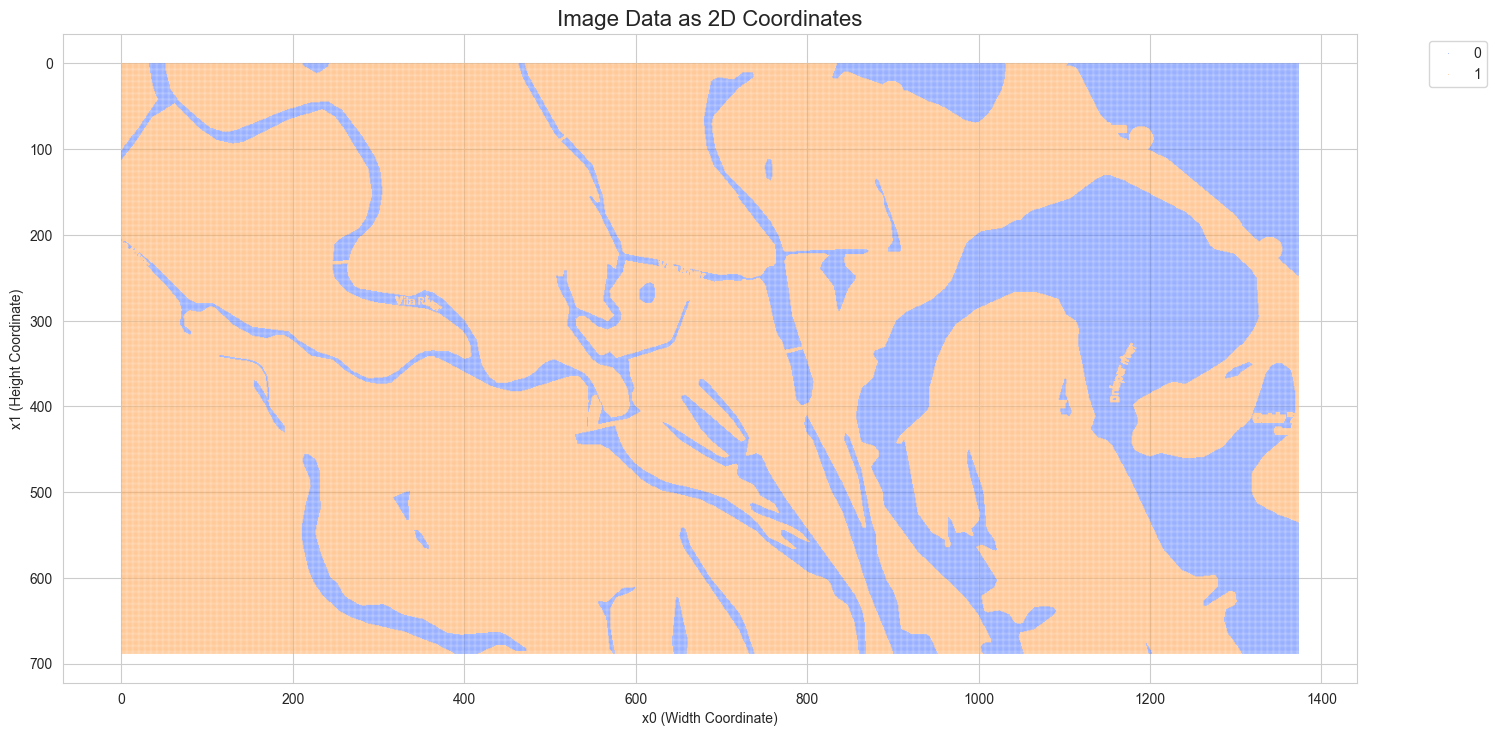

In [5]:
visualize_coordinate_dataframe(df_img)

## 2. Train a flat model

In [8]:
ann_wide_model = keras.Sequential([
    # Input layer: specify the shape of our features (x0, x1 -> 2 features)
    layers.InputLayer(shape=(2, )),
    
    # Hidden layer 1: N neurons
    # TODO 1: set any number neurons in this layer
    # TODO 2: try other activation functions
    layers.Dense(100, activation="relu"),
    
    # Output layer: 2 neurons for prediction of 2 classes
    layers.Dense(2, activation="softmax")
])

ann_wide_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 100)            │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 502 (1.96 KB)

 Trainable params: 502 (1.96 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
ann_wide_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [12]:
history = ann_wide_model.fit(
    df_img[["x0", "x1"]], 
    df_img["y"],
    epochs=20,   # TODO 3: you can set number of epochs as big as you require
    verbose=1,   # Show progress bars
)

Epoch 1/20
29584/29584 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - accuracy: 0.7712 - loss: 0.5824
Epoch 2/20
29584/29584 ━━━━━━━━━━━━━━━━━━━━ 40s 1ms/step - accuracy: 0.7910 - loss: 0.4811
Epoch 3/20
29584/29584 ━━━━━━━━━━━━━━━━━━━━ 41s 1ms/step - accuracy: 0.8124 - loss: 0.4282
Epoch 4/20
29584/29584 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - accuracy: 0.8239 - loss: 0.4096
Epoch 5/20
29584/29584 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step - accuracy: 0.8237 - loss: 0.4073
Epoch 6/20
29584/29584 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step - accuracy: 0.8247 - loss: 0.4057
Epoch 7/20
29584/29584 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - accuracy: 0.8253 - loss: 0.4048
Epoch 8/20
29584/29584 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step - accuracy: 0.8257 - loss: 0.4045
Epoch 9/20
29584/29584 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - accuracy: 0.8258 - loss: 0.4038
Epoch 10/20
29584/29584 ━━━━━━━━━━━━━━━━━━━━ 31s 1ms/step - accuracy: 0.8259 - loss: 0.4032
Epoch 11/20
29584/29584 ━━━━━━━━━━━━━━━━━━━━ 30s 1ms/step - accuracy: 0.8260 - loss: 0.40

In [13]:
_loss, _accuracy = ann_wide_model.evaluate(df_img[["x0", "x1"]], df_img["y"], verbose=0)

print("--- Model Evaluation ---")
print(f"Resulting Loss: {_loss:.4f}")
print(f"Resulting Accuracy: {_accuracy:.4f}")


--- Model Evaluation ---
Resulting Loss: 0.4008
Resulting Accuracy: 0.8071


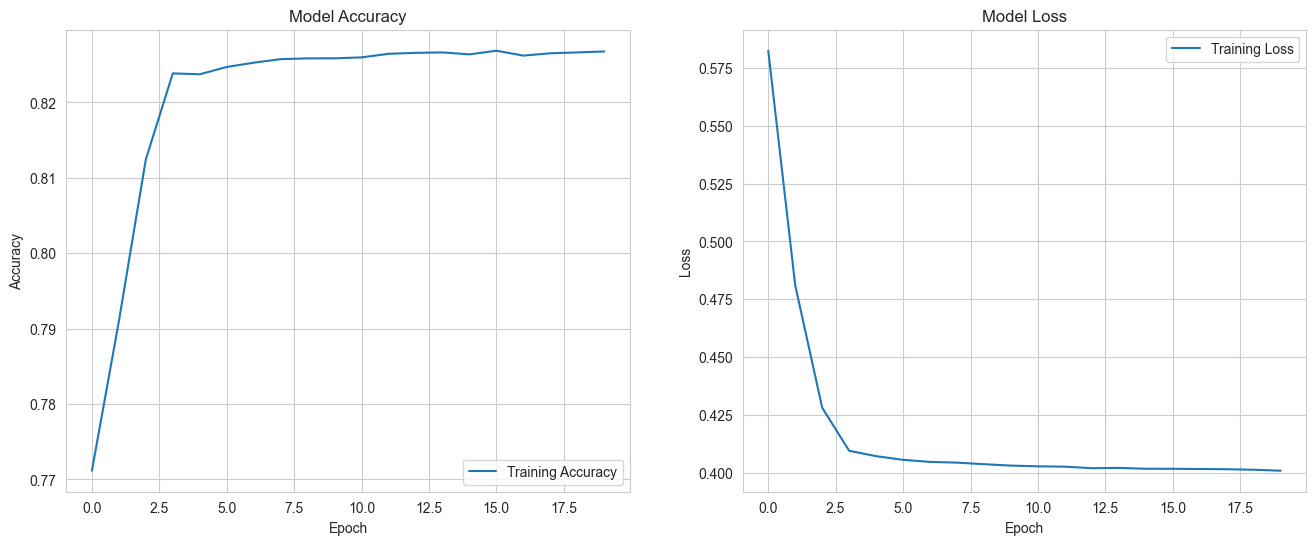

In [17]:
plot_history(history)

In [21]:
raw_predictions = ann_wide_model.predict(df_img[["x0", "x1"]])
df_img_test_vis["y_pred"] = np.argmax(raw_predictions, axis=1)

29584/29584 ━━━━━━━━━━━━━━━━━━━━ 22s 733us/step


Generating error plot... This may take a moment.


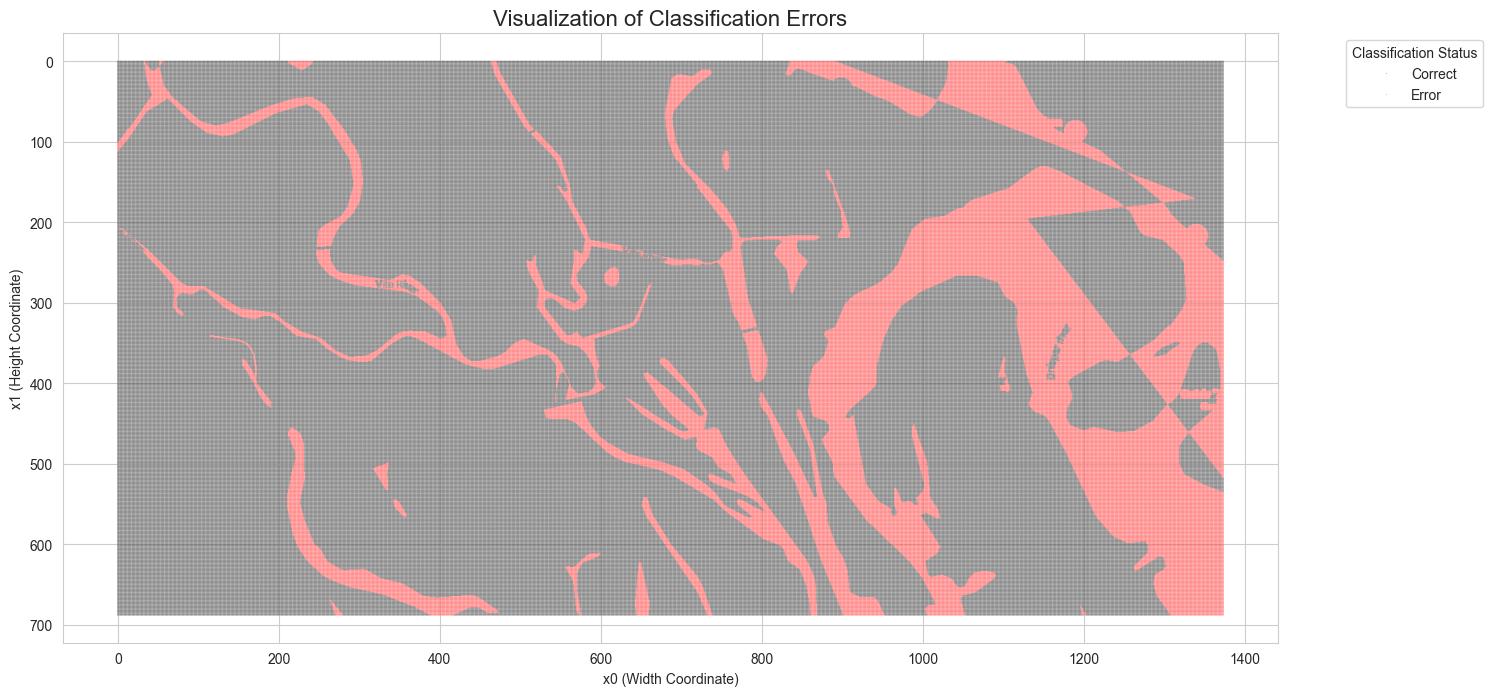

In [26]:
visualize_classification_errors(df_img_test_vis)

## Train a deep model

In [27]:
ann_deep_model = keras.Sequential([
    # Input layer: specify the shape of our features (x0, x1 -> 2 features)
    layers.InputLayer(shape=(2, )),
    
    # TODO 7: BEGIN try as many inner layers as your need
    
    # Hidden layer 1: N neurons
    # TODO 4: set any number neurons in this layer
    # TODO 5: try other activation functions
    layers.Dense(100, activation="relu"),
    
    # Hidden layer 2: M neurons
    # TODO 4: set any number neurons in this layer
    # TODO 5: try other activation functions
    layers.Dense(100, activation="relu"),
    
    # Hidden layer 3: K neurons
    # TODO 4: set any number neurons in this layer
    # TODO 5: try other activation functions
    layers.Dense(100, activation="relu"),
    
    # TODO 7: END of TODO
    
    # Output layer: 2 neurons for prediction of 2 classes
    layers.Dense(2, activation="softmax")
])

ann_deep_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 100)            │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,702 (80.87 KB)

 Trainable params: 20,702 (80.87 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
ann_deep_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [30]:
history = ann_deep_model.fit(
    df_img[["x0", "x1"]], 
    df_img["y"],
    epochs=10,   # TODO 3: you can set number of epochs as big as you require
    verbose=1,   # Show progress bars
)

Epoch 1/10
29584/29584 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step - accuracy: 0.8125 - loss: 0.4465
Epoch 2/10
29584/29584 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - accuracy: 0.8330 - loss: 0.4035
Epoch 3/10
29584/29584 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - accuracy: 0.8400 - loss: 0.3894
Epoch 4/10
29584/29584 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - accuracy: 0.8419 - loss: 0.3836
Epoch 5/10
29584/29584 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - accuracy: 0.8413 - loss: 0.3863
Epoch 6/10
29584/29584 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - accuracy: 0.8386 - loss: 0.3857
Epoch 7/10
29584/29584 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - accuracy: 0.8452 - loss: 0.3723
Epoch 8/10
29584/29584 ━━━━━━━━━━━━━━━━━━━━ 40s 1ms/step - accuracy: 0.8467 - loss: 0.3694
Epoch 9/10
29584/29584 ━━━━━━━━━━━━━━━━━━━━ 40s 1ms/step - accuracy: 0.8472 - loss: 0.3670
Epoch 10/10
29584/29584 ━━━━━━━━━━━━━━━━━━━━ 43s 1ms/step - accuracy: 0.8475 - loss: 0.3659


In [31]:
_loss, _accuracy = ann_deep_model.evaluate(df_img[["x0", "x1"]], df_img["y"], verbose=0)

print("--- Model Evaluation ---")
print(f"Resulting Loss: {_loss:.4f}")
print(f"Resulting Accuracy: {_accuracy:.4f}")

--- Model Evaluation ---
Resulting Loss: 0.3593
Resulting Accuracy: 0.8514


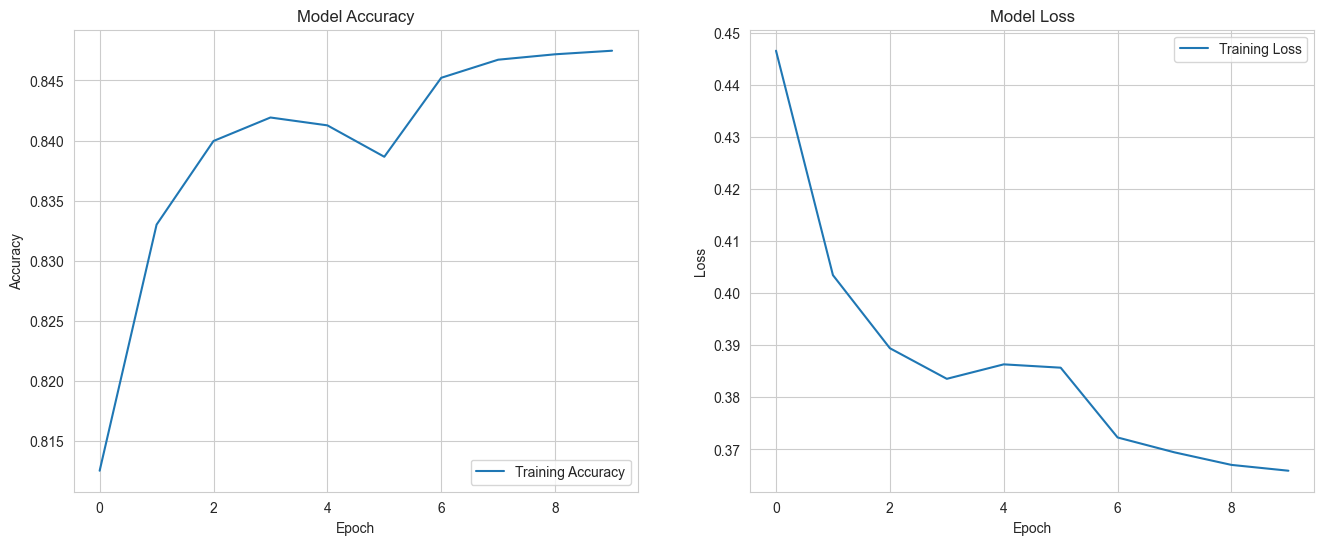

In [32]:
plot_history(history)

In [33]:
raw_predictions = ann_wide_model.predict(df_img[["x0", "x1"]])
df_img_test_vis["y_pred"] = np.argmax(raw_predictions, axis=1)

29584/29584 ━━━━━━━━━━━━━━━━━━━━ 24s 795us/step


Generating error plot... This may take a moment.


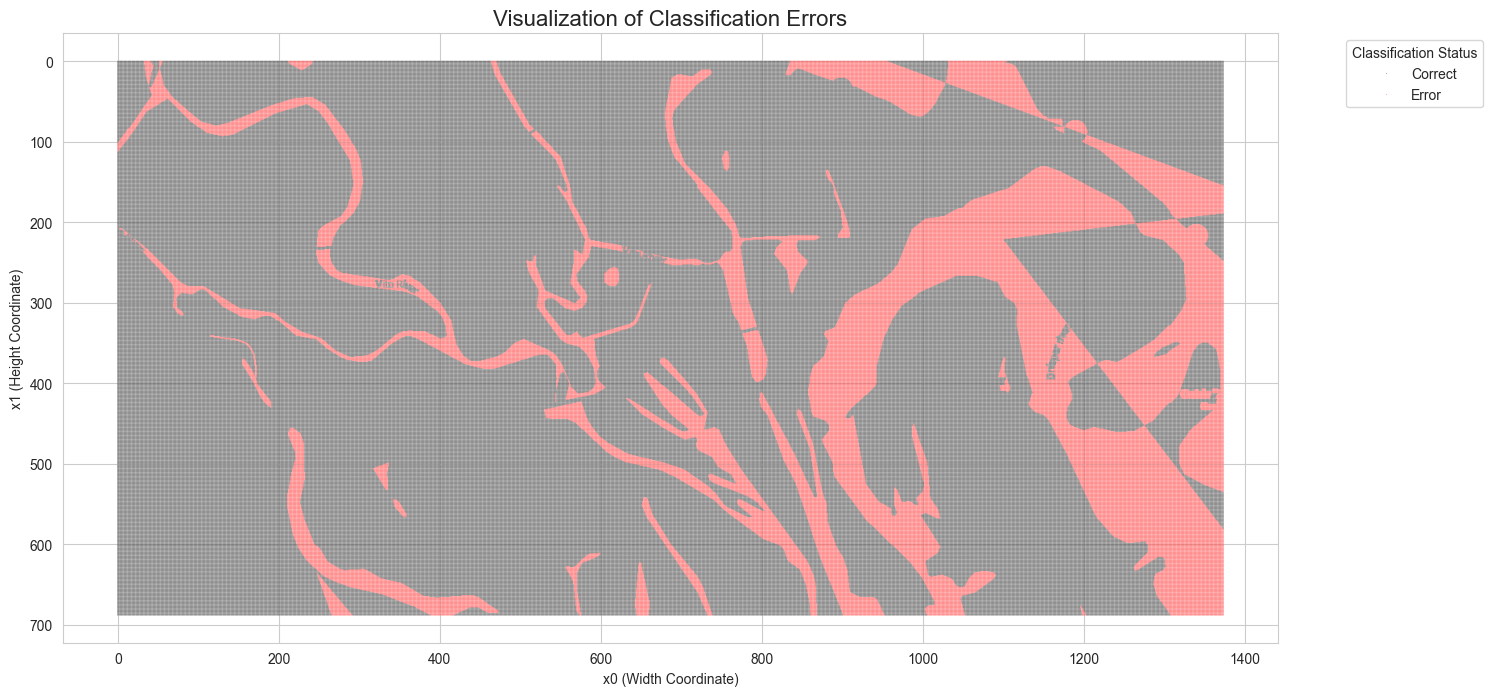

In [34]:
visualize_classification_errors(df_img_test_vis)

# Your experiments is here

# Conclusions on work